<center>

# Predicción de aprobacion de un préstamo

</center>

In [70]:
import sys
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff
from sklearn.utils import resample
from sklearn.metrics import log_loss
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans

 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler


from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import OneHotEncoder

In [100]:
prestamos = pd.read_csv('loan_data.csv')

In [72]:

prestamos["Loan_Status"] = prestamos["Loan_Status"].map({'Y': 1, 'N': 0})
prestamos["Loan_Status"].head()
print(prestamos["Loan_Status"].unique())

[0 1]


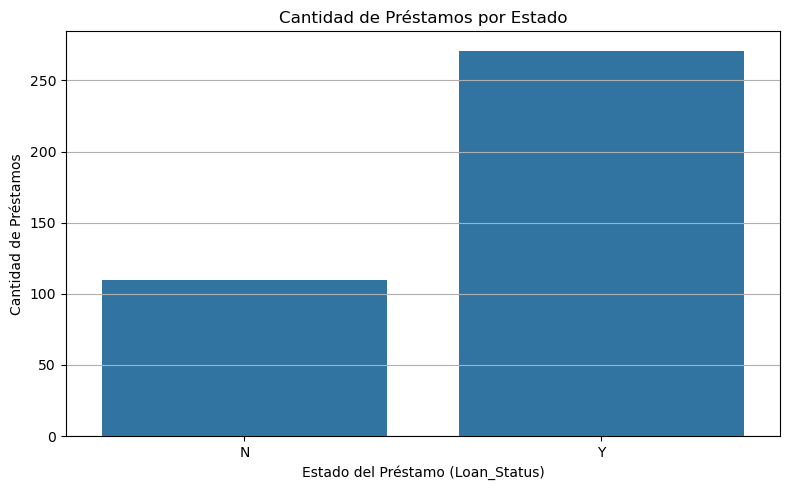

In [101]:
# Gráfico de conteo por estado del préstamo
plt.figure(figsize=(8, 5))
sns.countplot(x='Loan_Status', data=prestamos)
plt.title("Cantidad de Préstamos por Estado")
plt.xlabel("Estado del Préstamo (Loan_Status)")
plt.ylabel("Cantidad de Préstamos")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [73]:
prestamos["ingresos_cat"] = pd.cut(prestamos["ApplicantIncome"],
                                 bins = [0, 2600, 3333, 4288, 6000, np.inf],
                                   labels = [1, 2, 3, 4, 5])

In [74]:
#creamos los datasets estratificados
from sklearn.model_selection import train_test_split
strat_train_set, strat_test_set = train_test_split(prestamos, 
                                                   test_size=0.2, 
                                                   stratify=prestamos["ingresos_cat"], 
                                                   random_state=42)
 
print('Tamaño del train_set',strat_train_set.shape)
print('Tamaño del test_set',strat_test_set.shape)

Tamaño del train_set (304, 14)
Tamaño del test_set (77, 14)


In [75]:
# Separar las variables predictivas de la variable objetivo
prestamostrain = strat_train_set.drop("Loan_Status", axis=1)
prestamostrain_labels = strat_train_set["Loan_Status"].copy()
prestamostrain_labels.head()

74     1
44     1
178    1
283    1
293    1
Name: Loan_Status, dtype: int64

In [76]:
#Estos miden la capacidad de pago del solicitante y co-solicitante en relación al préstamo
def income_to_loan(X):
    total_income = X[:, [0]] + X[:, [1]]
    return total_income / (X[:, [2]] + 1e-5)

def income_to_loan_name(transformer, feature_names_in):
    return ["income_to_loan_ratio"]
#Estos sirven para analizar la dependencia del ingreso conjunto
def applicant_to_coapplicant(X):
    return X[:, [0]] / (X[:, [1]] + 1e-5)

def applicant_to_coapplicant_name(transformer, feature_names_in):
    return ["applicant_to_coapplicant_ratio"]
#Estos se usan para ver qué porcentaje del ingreso representa el préstamo
def loan_to_income(X):
    total_income = X[:, [0]] + X[:, [1]]
    return X[:, [2]] / (total_income + 1e-5)

def loan_to_income_name(transformer, feature_names_in):
    return ["loan_to_income_ratio"]
#Estos se usan para ver la carga mensual o anual del solicitante
def loan_to_term(X):
    return X[:, [0]] / (X[:, [1]] + 1e-5)

def loan_to_term_name(transformer, feature_names_in):
    return ["loan_to_term_ratio"]

In [77]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer
income_to_loan_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(income_to_loan, feature_names_out=income_to_loan_name),
    StandardScaler()
)

applicant_to_coapplicant_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(applicant_to_coapplicant, feature_names_out=applicant_to_coapplicant_name),
    StandardScaler()
)

loan_to_income_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(loan_to_income, feature_names_out=loan_to_income_name),
    StandardScaler()
)

loan_to_term_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(loan_to_term, feature_names_out=loan_to_term_name),
    StandardScaler()
)
from category_encoders import CountEncoder
# Pipeline para variables categóricas Ordinal
cat_count_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    CountEncoder()
)

# Pipeline para variables numéricas restantes
default_num_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)


In [78]:
preprocessing = ColumnTransformer([
    ("income_to_loan", income_to_loan_pipeline, ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]),
    ("applicant_to_coapplicant", applicant_to_coapplicant_pipeline, ["ApplicantIncome", "CoapplicantIncome"]),
    ("loan_to_income", loan_to_income_pipeline, ["ApplicantIncome", "CoapplicantIncome", "LoanAmount"]),
    ("loan_to_term", loan_to_term_pipeline, ["LoanAmount", "Loan_Amount_Term"]),
    ("cat", cat_count_pipeline, make_column_selector(dtype_include=object))  # <-- actualizamos esto
], remainder=default_num_pipeline)

In [79]:
# Aplica el preprocesamiento automátizado
X = preprocessing.fit_transform(prestamostrain)
print(type(X))
print(X.shape)

<class 'numpy.ndarray'>
(304, 13)


In [80]:
prestamostrainProc = pd.DataFrame(X,
                               columns=preprocessing.get_feature_names_out(),
                               index=prestamostrain.index)
prestamostrainProc.head(2)

,income_to_loan__income_to_loan_ratio,applicant_to_coapplicant__applicant_to_coapplicant_ratio,loan_to_income__loan_to_income_ratio,loan_to_term__loan_to_term_ratio,cat__0,cat__1,cat__2,cat__3,cat__4,cat__5,cat__6,remainder__Credit_History,remainder__ingresos_cat
74,-0.352710,1.461968,0.356319,0.034177,1.0,237.0,130.0,195.0,223.0,275.0,96.0,0.400381,1.177683
44,-0.232557,-0.825365,0.024008,0.074821,1.0,237.0,174.0,46.0,81.0,275.0,96.0,0.400381,0.367693


## Entranemiento de los modelos

In [81]:
from sklearn.metrics import   accuracy_score, confusion_matrix, classification_report

## SVC Maquina de soporte vectorial

In [82]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict
svc_cls = make_pipeline(preprocessing, SVC(C=10, gamma='auto', class_weight='balanced'))

y_pred_svc = cross_val_predict(svc_cls, prestamostrain, prestamostrain_labels, cv=3)

y_pred_svc[:10]

array([0, 1, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int64)

In [83]:

accuracy_svc = accuracy_score(prestamostrain_labels, y_pred_svc)


print(f"Accuracy: {accuracy_svc}")

print("Matriz de confusión:\n", confusion_matrix(prestamostrain_labels, y_pred_svc))
print("Reporte de clasificación:\n", classification_report(prestamostrain_labels, y_pred_svc))

Accuracy: 0.7039473684210527
Matriz de confusión:
 [[ 39  52]
 [ 38 175]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.51      0.43      0.46        91
           1       0.77      0.82      0.80       213

    accuracy                           0.70       304
   macro avg       0.64      0.63      0.63       304
weighted avg       0.69      0.70      0.70       304



## Random Forest

In [84]:
from sklearn.ensemble import RandomForestClassifier
 
forest_clf = make_pipeline(
    preprocessing,
    RandomForestClassifier(random_state=42)
)
y_pred_forest = cross_val_predict(forest_clf, prestamostrain, prestamostrain_labels, cv=10)

In [85]:
y_pred_forest

array([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,

In [86]:
# Random Forest no tiene decision_function, pero si genera la probabilidad de pertenecer a cada clase. 
y_probas_forest = cross_val_predict(forest_clf, prestamostrain, prestamostrain_labels, cv=3,
                                    method="predict_proba")

In [87]:
y_probas_forest[:10]

array([[0.15, 0.85],
       [0.27, 0.73],
       [0.19, 0.81],
       [0.59, 0.41],
       [0.27, 0.73],
       [0.08, 0.92],
       [0.14, 0.86],
       [0.26, 0.74],
       [0.76, 0.24],
       [0.07, 0.93]])

In [95]:
from sklearn.metrics import  accuracy_score

# Calcular métricas
accuracy_forest = accuracy_score(prestamostrain_labels, y_pred_forest)

print(f"Accuracy: {accuracy_forest}")

Accuracy: 0.7993421052631579


## LogisticRegression

In [96]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

# Usar regresión logística en lugar de lineal
log_reg = make_pipeline(preprocessing, LogisticRegression(max_iter=2000))


# Predicciones de clase
y_pred = cross_val_predict(log_reg, prestamostrain, prestamostrain_labels, cv=3)
print("Predicciones de clase:", y_pred[:5])

# Predicciones de probabilidad
y_proba = cross_val_predict(log_reg, prestamostrain, prestamostrain_labels, cv=3, method='predict_proba')[:, 1]
print("Probabilidades:", y_proba[:5])

Predicciones de clase: [1 1 1 0 1]
Probabilidades: [0.76592517 0.74894584 0.80510846 0.49196416 0.67502055]


In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
log_regression_acc = accuracy_score(prestamostrain_labels, y_pred)
print("Accuracy:", log_regression_acc )
print("Matriz de confusión:\n", confusion_matrix(prestamostrain_labels, y_pred))
print("Reporte de clasificación:\n", classification_report(prestamostrain_labels, y_pred))

Accuracy: 0.8223684210526315
Matriz de confusión:
 [[ 46  45]
 [  9 204]]
Reporte de clasificación:
               precision    recall  f1-score   support

           0       0.84      0.51      0.63        91
           1       0.82      0.96      0.88       213

    accuracy                           0.82       304
   macro avg       0.83      0.73      0.76       304
weighted avg       0.82      0.82      0.81       304



In [98]:
df = prestamostrain.copy()
df["Loan_Status"] = prestamostrain_labels

correlaciones = df.corr(numeric_only=True)["Loan_Status"].sort_values(ascending=False)
print(correlaciones)

Loan_Status          1.000000
Credit_History       0.581380
LoanAmount           0.017546
CoapplicantIncome    0.013778
ApplicantIncome      0.012895
Loan_Amount_Term    -0.073363
Name: Loan_Status, dtype: float64


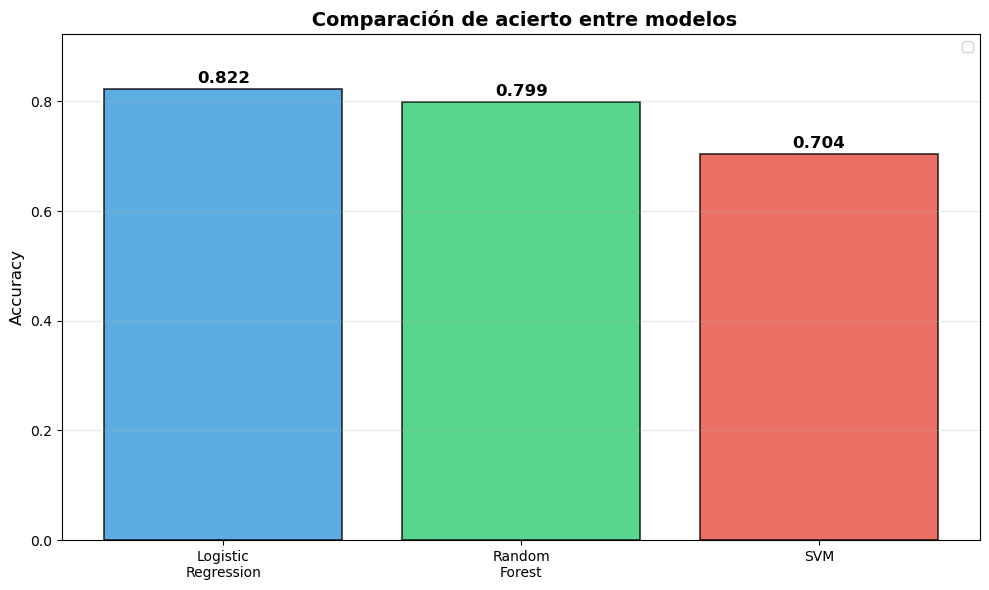

In [99]:
models = ['Logistic\nRegression', 'Random\nForest', 'SVM']
accuracies = [log_regression_acc, accuracy_forest, accuracy_svc]


colors = ['#3498db', '#2ecc71', '#e74c3c']

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors, alpha=0.8, 
               edgecolor='black', linewidth=1.2)


for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{acc:.3f}', 
             ha='center', va='bottom', fontweight='bold', fontsize=12)


plt.ylabel('Accuracy', fontsize=12)
plt.title(' Comparación de acierto entre modelos', 
          fontsize=14, fontweight='bold')
plt.ylim(0, max(accuracies) + 0.1)
plt.grid(True, alpha=0.3, axis='y')


plt.legend()

plt.tight_layout()
plt.show()


## Afinamiento de datos

## GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
param_grid = {
    "randomforestclassifier__n_estimators": [200, 300],
    "randomforestclassifier__max_depth": [5, 10, 15],  
    "randomforestclassifier__max_features": ["sqrt", "log2"],  
    "randomforestclassifier__min_samples_split": [5, 10], 
    "randomforestclassifier__min_samples_leaf": [2, 4],  
    "randomforestclassifier__class_weight": ["balanced"] 
}

grid_search = GridSearchCV(forest_clf, param_grid, cv=15)

In [39]:
import time
 
inicio = time.time()
grid_search.fit(prestamostrain,  prestamostrain_labels) 
fin = time.time()
(fin - inicio) / 60 

3.796353280544281

In [40]:
cv_res = pd.DataFrame(grid_search.cv_results_)

In [41]:
cv_res[:5]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestclassifier__class_weight,param_randomforestclassifier__max_depth,param_randomforestclassifier__max_features,param_randomforestclassifier__min_samples_leaf,param_randomforestclassifier__min_samples_split,param_randomforestclassifier__n_estimators,...,split8_test_score,split9_test_score,split10_test_score,split11_test_score,split12_test_score,split13_test_score,split14_test_score,mean_test_score,std_test_score,rank_test_score
0,0.249520,0.013079,0.020474,0.001329,balanced,5,sqrt,2,5,200,...,0.8,0.85,0.80,0.9,0.8,0.80,0.9,0.800476,0.073675,7
1,0.335134,0.004221,0.022982,0.000518,balanced,5,sqrt,2,5,300,...,0.8,0.85,0.80,0.9,0.8,0.80,0.9,0.800476,0.073675,7
2,0.235585,0.002649,0.019656,0.000687,balanced,5,sqrt,2,10,200,...,0.8,0.85,0.85,0.9,0.8,0.80,0.9,0.803968,0.080450,1
3,0.338198,0.019607,0.022903,0.000556,balanced,5,sqrt,2,10,300,...,0.8,0.85,0.85,0.9,0.8,0.80,0.9,0.803968,0.080450,1
4,0.239810,0.012511,0.020078,0.001145,balanced,5,sqrt,4,5,200,...,0.8,0.85,0.80,0.9,0.8,0.75,0.9,0.793968,0.074540,15


In [42]:
#mejores parametros
print(grid_search.best_params_)
print(grid_search.best_score_)

{'randomforestclassifier__class_weight': 'balanced', 'randomforestclassifier__max_depth': 5, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 10, 'randomforestclassifier__n_estimators': 200}
0.8039682539682541


# Evaluar el modelo con el "test set"

In [43]:
from sklearn.metrics import accuracy_score, log_loss
from sklearn.utils import resample
import numpy as np


final_model = grid_search.best_estimator_


X_test = strat_test_set.drop("Loan_Status", axis=1)
y_test = strat_test_set["Loan_Status"]


final_predictions = final_model.predict(X_test)
final_proba = final_model.predict_proba(X_test)[:, 1]


accuracy = accuracy_score(y_test, final_predictions)
print(" Resultados en Test Set:")
print(f"Accuracy     : {accuracy:.4f}")

 Resultados en Test Set:
Accuracy     : 0.8961


In [58]:
n_bootstraps = 1000
logloss_bootstrap = []

for _ in range(n_bootstraps):
    X_resampled, y_resampled = resample(X_test, y_test)
    
    probs_resampled = final_model.predict_proba(X_resampled)[:, 1]
    
    logloss_resampled = log_loss(y_resampled, probs_resampled)
    logloss_bootstrap.append(logloss_resampled)

lower = np.percentile(logloss_bootstrap, 2.5)
upper = np.percentile(logloss_bootstrap, 97.5)
mean_logloss = np.mean(logloss_bootstrap)
print(f"\nIC 95% del Log Loss (bootstrap): [{lower:.4f}, {upper:.4f}]")


IC 95% del Log Loss (bootstrap): [0.3907, 0.5145]


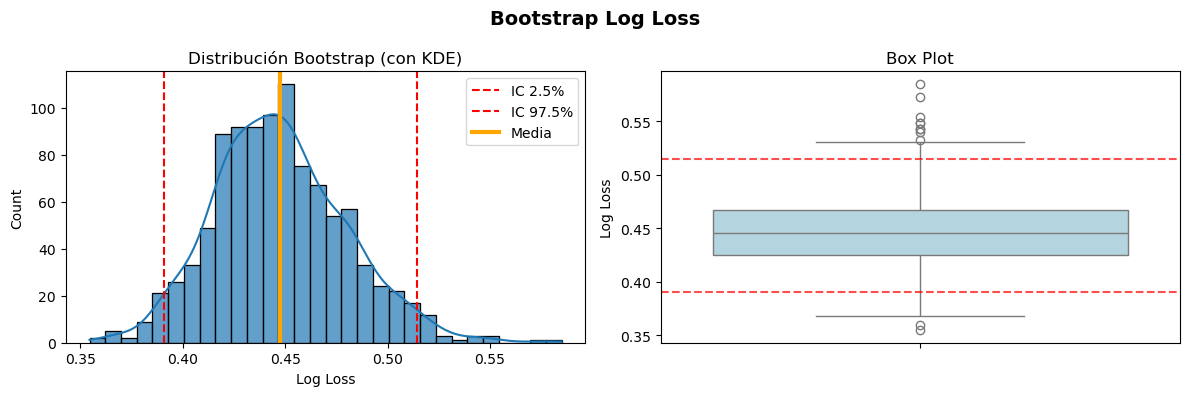

In [61]:
# Gráfico adicional con seaborn
plt.figure(figsize=(12, 4))

# Subplot 1: Distribución
plt.subplot(1, 2, 1)
sns.histplot(logloss_bootstrap, bins=30, kde=True, alpha=0.7)
plt.axvline(lower, color='red', linestyle='--', label=f'IC 2.5%')
plt.axvline(upper, color='red', linestyle='--', label=f'IC 97.5%')
plt.axvline(mean_logloss, color='orange', linewidth=3, label='Media')
plt.xlabel('Log Loss')
plt.title('Distribución Bootstrap (con KDE)')
plt.legend()

# Subplot 2: Boxplot 
plt.subplot(1, 2, 2)
sns.boxplot(y=logloss_bootstrap, color='lightblue')
plt.ylabel('Log Loss')
plt.title('Box Plot')

# Agregar líneas de IC
plt.axhline(y=lower, color='red', linestyle='--', alpha=0.7)
plt.axhline(y=upper, color='red', linestyle='--', alpha=0.7)

plt.suptitle('Bootstrap Log Loss', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()